## Question 

_Using this cell, please write a short, clear paragraph explaining what question you plan to answer in this notebook. Your question can be narrow (e.g. can we predict a dog's height from its weight) or broad (e.g. what features are important or unimportant in predicting the price of a house). Briefly describe why your question is important and how you plan to answer. Be sure to explain what is imaginative, creative or ambitious about your planned work! For instance, will you spend a lot of time defining new features, will you be working with hard-to-get data, will your work inform a major theoretical debate? Be sure to ask a question you can actually start to answer using machine learning techniques!


My question is -- Can we predict the citation count of a paper published in a peer-reviewed journal using the information given only in the abstract of the paper?
This question is interesting because it can help to identify how impactful a paper is likely to be in a given amount of time. This metric can be useful for high-impact journals when they are deciding whether a paper is appropriate for being published their journal or not. However, I would use this metric with caution and only as a weak indicator because it is far from being accurate enough to be used to make important publishing decisions. In addition to this, this metric is derived from the data collected in the past and is not necessarily an indicator of the direction in which a particular field might be going in the future. It would be more appropriate as an identifier for an author of a paper as it can help them gauge the perceived impact of their own paper as well gain some info about the kinds of topics that are being widely-studied in a field.

I have chosen to look at papers from a specific topic -- Quantum computing, published in the years 2009-2010. My model does not depend on these choices and can be used for any topic and year(s), provided that the data is available on the ADS server.

I have spent most of my time in defining features and feature selection/extraction. As my features are words from the abstract, I have cleaned the raw data by removing unimportant words/symbols and converted words into a common form so that a single word appearing in different forms (noun, adjective, adverb, verb, etc.) is counted as the same word instead of different words by the classifier. I have also spent some time training different classifiers and figuring out which one is best-suited for achieving the goals of this project. However, for the sake of brevity and clear presentation, I will present the results from just one classifier here. 



## Importing libraries

In [1]:
# importing libraries

import keyring
import requests
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm


# if running this code for the first time and the following is not downloaded yet, uncomment the following lines
# and download these.

#f = nltk.download('wordnet')
#f = nltk.download('averaged_perceptron_tagger')
#f = nltk.download('stopwords')
#f = nltk.download('punkt')

from nltk.corpus import wordnet as wn

### Data collection:

I have collected data about these papers, i.e., their abstract and citation count, from the  SAO/NASA Astrophysics Data System (ADS) (https://ui.adsabs.harvard.edu/), which is publicly available. I have extracted data from their server using an API.

I will be splitting data using sklearn which divides data into random partitions for a user-specified partition fraction. I have chosen a split of 60-40 for training and test+validation sets. I have further divided the test+validation set into a test and validation set using a split of 50-50. This split makes sense for my data as I do not have a lot of instances, i.e., <10,000 points.




In [2]:
# setting my API token for adsabs.harvard.edu

keyring.set_password("ADS_API_TOKEN", "ADS_API_TOKEN", "SaRvDR5CxyiX3cosvbYMilJRrEZgb8OpdAHnOzoW")

# setting search parameters for the data we want to extract using the API

year_str_list = [2009,2010] #,2011,2012,2013,2014]
list_of_keywords = ["quantum","computing"]
keyword_str = '"'
for ik, word in enumerate(list_of_keywords):
    keyword_str += word
    if ik < len(list_of_keywords)-1:
        keyword_str += "%20"
keyword_str += '"'

# get data from API

r_list = []
for iy,year_str in enumerate(year_str_list):

    token = keyring.get_password("ADS_API_TOKEN", "ADS_API_TOKEN")
    r = requests.get(
        r'https://api.adsabs.harvard.edu/v1/search/query?q=year%3A'+str(year_str)+'%20full%3A'+keyword_str+'&sort=date%20desc%2C%20&fl=bibcode&fl=abstract&fl=citation_count&rows=2000',
        headers={"Authorization": "Bearer " + token},
    )
    r_list.append(r)
    print(r) # if this prints <Response [200]>, then it was a success
 

<Response [200]>
<Response [200]>


## Cleaning data

In [3]:
# creating lists for raw data and raw labels
# cleaning the dataset by removing data for which either the citation count or the abstract is missing

abstract_list = [] # features
citation_count_list = [] # labels

for iy,year_str in enumerate(year_str_list):
    index = 0
    print('Year='+str(year_str))
    for ii in r_list[iy].json()["response"]["docs"]:
        try:
            if ii["citation_count"] == 0: 
                # we skip data with 0 citation counts because this may include conference proceedings
                # and we wish to have only peer-reviewed journal articles included here
                continue
            elif ii["abstract"] in abstract_list: # remove repetitions in data, if any
                index += 1 
                continue
            else:
                abstract_list.append(ii["abstract"])
                citation_count_list.append(ii["citation_count"])
                index += 1
        except:
            print('Data missing at: ' + str(index))

Year=2009
Data missing at: 124
Data missing at: 201
Data missing at: 289
Data missing at: 413
Data missing at: 426
Data missing at: 958
Data missing at: 1241
Data missing at: 1326
Data missing at: 1338
Data missing at: 1397
Year=2010
Data missing at: 915
Data missing at: 1237
Data missing at: 1555
Data missing at: 1591


## Converting continuous data labels into discrete class labels

In [4]:
# create labels and assign those labels to the raw label list

label_list = [ 'Low', 'Medium', 'High'] # Low: 1-5, Medium: 6-20, High: >20
label_num_list = [0,1,2]
label_lower_threshold_list = [1,6,21]
label_upper_threshold_list = [5,20,np.max(np.array(citation_count_list))]

data_label_list = []
for ic, count in enumerate(citation_count_list):
    for il in range(0, len(label_list)):
        if count in np.arange(label_lower_threshold_list[il],label_upper_threshold_list[il]+1,1):
            data_label = label_num_list[il]
            data_label_list.append(data_label)
            break

### Histogram of data labels: shows that the data is almost uniformly distributed across the three labels

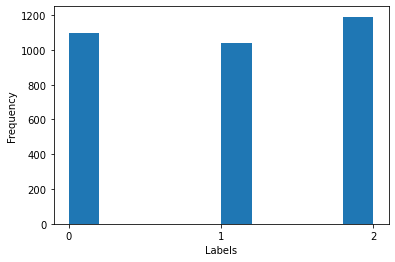

In [12]:
plt.hist(data_label_list, density=False)
plt.xlabel("Labels")
plt.xticks(label_num_list)
plt.ylabel("Frequency")
plt.show()

## Splitting data into training, cross validation and test datasets

In [6]:
# split data into train and test sets using sklearn with random partitions

x_train, x_rest, y_train, y_rest = train_test_split(abstract_list, data_label_list, test_size=0.4, train_size=0.6)
x_cv, x_test, y_cv, y_test = train_test_split(x_rest, y_rest, test_size=0.5, train_size=0.5)

## Feature extraction of text data 

In [7]:
# feature extraction

# n-grams

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

# skip-grams

def skip_gram_features(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),    
    # keep only words, not numbers
    text_alphanum = re.sub('[^a-z]', ' ', text)
    
    
    # keep only thise words which have more than 3 letters:
    words_list = text_alphanum.split()
    words_list_grter_than_3 = []
    for w in words_list:
        if len(w)>3:
            words_list_grter_than_3+=[w]
    words_list = words_list_grter_than_3
    
    
    # Remove Stop words and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. 
    # By default it is set to Noun
    
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    tag_map['S'] = wn.ADJ_SAT
    
    
    # Declaring Empty List to store the words that follow the rules for this step
    
    Final_words = []
    
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    entry = words_list
    for word, tag in pos_tag(entry):
    # Following condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
            
    # The processed set of words for each instance will be stored now 
    
    words_list = Final_words
    
    # extract all n-grams of length n specified by ngram_range
    
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(words_list, n) 
    
    # now convert word(s) in between the edge words to asterisk(s)
    
    for n in range(ngram_range[0], ngram_range[1]+1):
        if n > 2: #n == 3 or n == 4:
            temp_ngrams = ngrams(words_list, n) 
            for it in range(0, len(temp_ngrams)):
                words_in_ngram = temp_ngrams[it].split()
                new_ngram = words_in_ngram[0]
                for iw in range(1, len(words_in_ngram)-1):
                    new_ngram += ' * '
                new_ngram += words_in_ngram[-1]
                features_in_text += [new_ngram]
                

    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return [Counter(features_in_text),features_in_text] 


## Selecting features upto a percentile -- hyperparameter #1

In [37]:
# Feature selection

ngr = (1,1)

per_list = np.array([10,20,30,40,50,100])  #np.array([10,20,30,40,50,60,70,80,100]) 

vect = DictVectorizer()

x_all_num = vect.fit_transform(skip_gram_features(d, ngram_range=ngr)[0] for d in abstract_list)


feature_names = np.asarray(vect.get_feature_names())


# split data into train, test and validation sets using sklearn with random partitions

x_train, x_rest, y_train, y_rest = train_test_split(x_all_num, data_label_list, test_size=0.4, train_size=0.6)
x_cv, x_test, y_cv, y_test = train_test_split(x_rest, y_rest, test_size=0.5, train_size=0.5)


x_train_final_list = []
x_cv_final_list = []
x_test_final_list = []
for ip, per in enumerate(per_list):
    selection = SelectPercentile(percentile=per, score_func=chi2)
    x_train_final_list.append(selection.fit_transform(x_train, y_train))
    x_cv_final_list.append(selection.transform(x_cv))
    x_test_final_list.append(selection.transform(x_test))
    


In [38]:
print(len(feature_names))
print(len(citation_count_list))

9837
3328


### Since number of features (=9837) >> number of instances (=3328), we will go with a linear classifier, i.e., Logistic regression


## Fitting a classifier model to the training data and tuning the hyperparameters with the validation data

In [42]:

# these are the C values we will compare -- hyperparameter #2


C_list = [0.001, 0.01, 0.1, 1.0]

training_acc_arr_C = np.zeros(( len(per_list), len(C_list)))
cv_acc_arr_C = np.zeros(( len(per_list), len(C_list)))
precision_arr_C = np.zeros(( len(per_list), len(C_list), len(label_list)))
recall_arr_C = np.zeros(( len(per_list), len(C_list),  len(label_list)))
fscore_arr_C = np.zeros(( len(per_list), len(C_list), len(label_list)))

for ip in range(0, len(per_list)):
    for ic,Cval in enumerate(C_list):
        classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=Cval, tol=1e-10, max_iter=1000, random_state=123)
        classifier.fit(x_train_final_list[ip], y_train)
        training_acc_arr_C[ip,ic] = accuracy_score(y_train, classifier.predict(x_train_final_list[ip]))
        cv_acc_arr_C[ip,ic] = accuracy_score(y_cv, classifier.predict(x_cv_final_list[ip]))
        prec, recall, fscore, _ = precision_recall_fscore_support(y_cv, classifier.predict(x_cv_final_list[ip]), average=None, labels=label_num_list)
        precision_arr_C[ip,ic] = prec
        recall_arr_C[ip,ic] = recall
        fscore_arr_C[ip,ic] = fscore

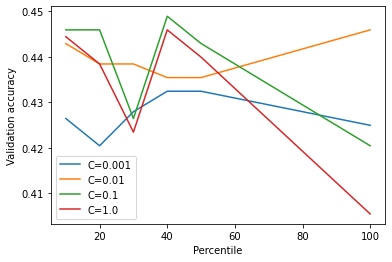

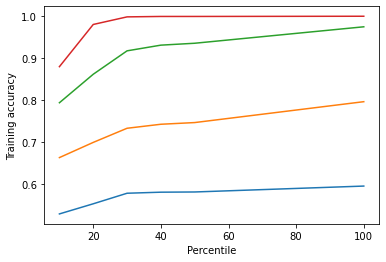

In [44]:
for ic,c in enumerate(C_list):
    plt.plot(per_list,cv_acc_arr_C[:,ic],label='C='+str(C_list[ic]))
plt.ylabel('Validation accuracy')
plt.xlabel('Percentile')
plt.legend(loc='best')
plt.show()
for ic,c in enumerate(C_list):
    plt.plot(per_list,training_acc_arr_C[:,ic])
plt.ylabel('Training accuracy')
plt.xlabel('Percentile')
plt.show()


# Test the best hyperparameters against the test data

In [52]:
Cval = 0.1
ip = 3 # corresponds to percentile = 40

classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=Cval, tol=1e-10, max_iter=1000, random_state=123)
classifier.fit(x_train_final_list[ip], y_train)
training_acc = accuracy_score(y_train, classifier.predict(x_train_final_list[ip]))
cv_acc = accuracy_score(y_cv, classifier.predict(x_cv_final_list[ip]))
test_pred = (classifier.predict(x_test_final_list[ip]))
test_pred = test_pred.astype(int)
test_acc = accuracy_score(y_test, test_pred)
prec, recall, fscore, _ = precision_recall_fscore_support(y_test, test_pred, average=None, labels=label_num_list)


In [60]:
print("Cross validation accuracy: " +str(cv_acc))
print("Test accuracy: " +str(test_acc))

Cross validation accuracy: 0.44894894894894893
Test accuracy: 0.4444444444444444


# Results

We achieve a test accuracy of around 44% which is much higher than the accuracy expected from random assignment of labels (=1/3). We also see that our cross validation accuracy and test accuracy are almost equal, thus implying that our model and the choice of hyperparameters is generalised enough to predict using new data. 



# Error analysis using confusion matrix

As we can see, the precision and recall is highest for label = "High". This is possibly because the division of the data is such that this label has the largest number of instances and hence, it is better learned by the model. In addition to this, we see that the label "Medium" has the lowest precision and recall because of having fewer training instances in that class. 




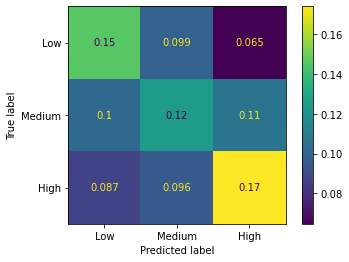

In [56]:
# create confusion matrix

cm = confusion_matrix(y_test, test_pred, labels = label_num_list, normalize='all') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_list)

# Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
# If None, confusion matrix will not be normalized.
disp.plot()

plt.show()


In [59]:
for il, lab in enumerate(label_list):
    print("Label = "+str(lab))
    print("Precision = "+str(prec[il]))
    print("Recall = "+str(recall[il]))
    

Label = Low
Precision = 0.4349775784753363
Recall = 0.470873786407767
Label = Medium
Precision = 0.38967136150234744
Recall = 0.3738738738738739
Label = High
Precision = 0.5043478260869565
Recall = 0.48739495798319327


# Summary

We have created a model for predicting citation count of a paper given its abstract with accuracy greater than random.


## Scope for improvement:

We might be able to improve the model by collecting more data as we notice in the beginning that the number of features is much greater than the number of instances. It might be possible to further improve the model by eliminating words which are not relevant to a given topic as well as those words which are too frequent and do not contribute to the information needed for predicting citation count. 